In [48]:
import pandas as pd
import pdb
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
import itertools
from IPython.display import display, HTML
pd.set_option('display.max_rows', 500)

In [3]:
data  = pd.read_csv("data/featureslogfile_Budget_500_vs_Budget_500_GPM100_NoSelfPlay.txt", sep = '\t')
#data  = pd.read_csv("data/2Player_FG1E_Supply_AllYears_Traces.txt", sep = ' ')
print(data)
print(data.columns)

       GameID  Player  Round  Turn  CurrentScore  SCORE  SCORE_ADV  ORDINAL  \
0         2.0     0.0    0.0   0.0           4.0   0.08       0.04      0.5   
1         2.0     1.0    0.0   0.0           3.0   0.06      -0.04      1.0   
2         2.0     0.0    0.0   1.0           4.0   0.08       0.04      0.5   
3         2.0     1.0    0.0   1.0           3.0   0.06      -0.04      1.0   
4         2.0     0.0    1.0   0.0           4.0   0.08       0.04      0.5   
...       ...     ...    ...   ...           ...    ...        ...      ...   
23833   201.0     1.0   50.0   1.0          83.0   1.66       1.12      0.5   
23834   201.0     0.0   51.0   0.0          55.0   1.10      -1.12      1.0   
23835   201.0     1.0   51.0   0.0          83.0   1.66       1.12      0.5   
23836   201.0     0.0   51.0   1.0          55.0   1.10      -1.36      1.0   
23837   201.0     1.0   51.0   1.0          89.0   1.78       1.36      0.5   

       OUR_TURN  HAS_WON  ...  SENTRY  WITCH  ARTIS

In [4]:
#LOGS_FROM_TAG = False #if false, logs are from parsed online player logs
LOGS_FROM_TAG = True

NOOFPLAYERS = 2 #note, keep this fixed and dont change it - we always assume there are only two players
agents = ['MCTS_Medium_A', 'MCTS_Medium_B'] #arbitrary labels for players (whether AI based or not)
#agents = ['PlayerA', 'PlayerB']

#if using TAG, parameters for round robin tournament
games_per_matchup = 100
self_play = False
NoOfGames = 2 * games_per_matchup
if self_play == True:
    NoOfGames = 4 * games_per_matchup
    
#if not using TAG, determine no of games 
if LOGS_FROM_TAG == False:
    NoOfGames = data['GameID'].max()  + 1 #GameID starts at zero

In [5]:
#define columns of interest 
#card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_SD = ['ARTISAN', 'BANDIT', 'BUREAUCRAT', 'CHAPEL', 'FESTIVAL', 'GARDENS', 'SENTRY', 'THRONE_ROOM', 'WITCH',
                 'WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_FG1E = ['CELLAR','MARKET','MILITIA','MINE','MOAT','REMODEL','SMITHY','VILLAGE',
                'WOODCUTTER','WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types = card_types_SD
index_cols = ['Player', 'GameID'] #used to group traces
non_card_types_round_indep_cols = ['AgentName', 'Win', 'FinalScore', 'TotalRounds'] #additional round indepedent values we want to investigate
cols = index_cols + non_card_types_round_indep_cols + ['Round'] + card_types #final set of cols to keep

In [6]:
#label all games with corresponding agent names
if LOGS_FROM_TAG == True:
    #first generate match-ups
    matchups = []
    if self_play:
        for agent1 in agents:
            for agent2 in agents:
                matchups.append((agent1, agent2))
    else:
        matchups = list(itertools.permutations(agents, 2))

    #function to map gameID to match-up
    def gameID_to_matchup(game_id, player_no, matchup_list, no_games_per_matchup, min_game_id):
        game_group = int((game_id - min_game_id)/no_games_per_matchup)
        matchup = matchup_list[game_group]
        agent1, agent2 = matchup
        if player_no == 0:
            return agent1
        else:
            return agent2

    #add agent names to data set
    min_GameID = data['GameID'].min()
    data['AgentName'] = data.apply(lambda row: gameID_to_matchup(row['GameID'], row['Player'], matchups, games_per_matchup, min_GameID), axis = 1)                         

In [7]:
#we can only record events each turn so we need to use the final turn in each round for each player to determine their
#deck at the end of the round
if LOGS_FROM_TAG:
    print(data['Turn'].unique())
    data = data[data['Turn'] == 1]

[0. 1.]


In [8]:
#all play taces in a single data frame
traces = data.loc[:, cols]
print(traces)

       Player  GameID      AgentName  Win  FinalScore  TotalRounds  Round  \
2         0.0     2.0  MCTS_Medium_A  0.0        29.0         17.0    0.0   
3         1.0     2.0  MCTS_Medium_B  1.0        33.0         17.0    0.0   
6         0.0     2.0  MCTS_Medium_A  0.0        29.0         17.0    1.0   
7         1.0     2.0  MCTS_Medium_B  1.0        33.0         17.0    1.0   
10        0.0     2.0  MCTS_Medium_A  0.0        29.0         17.0    2.0   
...       ...     ...            ...  ...         ...          ...    ...   
23829     1.0   201.0  MCTS_Medium_A  1.0        89.0         51.0   49.0   
23832     0.0   201.0  MCTS_Medium_B  0.0        55.0         51.0   50.0   
23833     1.0   201.0  MCTS_Medium_A  1.0        89.0         51.0   50.0   
23836     0.0   201.0  MCTS_Medium_B  0.0        55.0         51.0   51.0   
23837     1.0   201.0  MCTS_Medium_A  1.0        89.0         51.0   51.0   

       ARTISAN  BANDIT  BUREAUCRAT  ...  THRONE_ROOM  WITCH  WORKSHOP  CURS

In [18]:
#format needed is a list of list of vectors
#each row corrsponds to single player's play trace, each entry for a column corresponds
#to the deck composition
#(n_games * n_players, game_length (is variable), (d1,...d17))
list_agents = []
list_traces = []
for gameID in traces['GameID'].unique():
    for player in [0,1]:
        single_player_game = traces[(traces['GameID'] == gameID) & (traces['Player'] == player)]
        single_player_game.sort_values(by = ['Round'])
        single_player_game_cards_no = single_player_game[card_types]
        labelled_matrix = (single_player_game['AgentName'].iloc[0], single_player_game_cards_no.to_numpy())
        list_agents.append(labelled_matrix[0])
        list_traces.append(labelled_matrix[1])

In [57]:
print(list_traces[8])
print(len(list_traces))
for trace in list_traces:
    print(trace.shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 1. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 2. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 3. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 1. 3. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 1. 4. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3. 1. 4. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3. 1. 5. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3. 1. 6. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3. 2. 6. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 3. 2. 6. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 3. 2. 6. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 3. 3. 6. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 2. 1. 3. 3. 6. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 2. 2. 3. 3. 6. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 3. 2. 3. 3. 6. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 3. 2. 3. 4. 6. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 3. 2. 3. 5. 6. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 3. 2. 4. 5. 6. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.

In [59]:
X = to_time_series_dataset(list_traces)
num_clusters = 2
km = TimeSeriesKMeans(n_clusters= num_clusters, metric="dtw", max_iter=50,
                      random_state=0).fit(X)
print(km.labels_)

[1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0
 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1
 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0
 0 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1
 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0
 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0
 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0
 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1
 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0
 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0]


In [58]:
display(pd.DataFrame(km.cluster_centers_[1]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.008696,0.026087,0.000000,0.000000,0.013043,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.013043,3.000000,0.000000,0.508696,7.026087
1,0.000000,0.008696,0.026087,0.000000,0.000000,0.013043,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.013043,3.000000,0.000000,0.926087,7.030435
2,0.000000,0.008696,0.026087,0.000000,0.000000,0.013043,0.000000,0.000000,0.000000,0.730435,0.000000,0.000000,0.013043,3.000000,0.000000,0.926087,7.030435
3,0.000000,0.008696,0.026087,0.000000,0.000000,0.013043,0.000000,0.000000,0.000000,0.730435,0.000000,0.000000,0.013043,3.000000,0.000000,0.930435,7.030435
4,0.000000,0.008696,0.026087,0.000000,0.000000,0.013043,0.000000,0.000000,0.000000,0.730435,0.000000,0.000000,0.013043,3.000000,0.000000,0.930435,7.030435
5,0.000000,0.008696,0.026087,0.000000,0.000000,0.013043,0.000000,0.000000,0.000000,0.730435,0.000000,0.000000,0.013043,3.000000,0.000000,0.930435,7.030435
6,0.000000,0.008696,0.026087,0.000000,0.000000,0.013043,0.000000,0.000000,0.000000,0.730435,0.000000,0.000000,0.013043,3.000000,0.000000,0.930435,7.030435
7,0.000000,0.008696,0.026087,0.000000,0.000000,0.013043,0.000000,0.000000,0.000000,0.730435,0.000000,0.000000,0.013043,3.000000,0.000000,0.930435,7.030435
8,0.000000,0.008696,0.026087,0.000000,0.000000,0.013043,0.000000,0.000000,0.000000,0.730435,0.000000,0.000000,0.013043,3.000000,0.000000,0.930435,7.030435
9,0.000000,0.008696,0.026087,0.000000,0.000000,0.013043,0.000000,0.000000,0.000000,0.730435,0.000000,0.000000,0.013043,3.000000,0.000000,0.930435,7.030435


In [47]:
select_cols = ['DUCHY' + "_R" + str(r) for r in range(0, maxNoOfRounds)]
print(df_final_clusters.iloc[0][select_cols])

DUCHY_R0          0.0
DUCHY_R1          0.0
DUCHY_R2     0.005882
DUCHY_R3     0.005882
DUCHY_R4     0.005882
               ...   
DUCHY_R60    3.235426
DUCHY_R61    1.958132
DUCHY_R62    3.194444
DUCHY_R63    3.718861
DUCHY_R64    3.602198
Name: 0, Length: 65, dtype: object


In [60]:
df_cluster_centres = []
for cluster in range(0,num_clusters):
    df_cluster_centres.append(pd.DataFrame(km.cluster_centers_[cluster].flatten()).transpose())
print(df_cluster_centres)

[   0         1         2     3     4     5     6     7     8         9     \
0   0.0  0.141176  0.029412   0.0   0.0   0.0   0.0   0.0   0.0  0.035294   

   ...      1095  1096      1097      1098      1099      1100     1101  \
0  ...  1.149451   1.2  1.276923  0.312088  5.279121  3.602198  4.92967   

       1102      1103       1104  
0  7.312088  7.413187  10.092308  

[1 rows x 1105 columns],    0         1         2     3     4         5     6     7     8     9     \
0   0.0  0.008696  0.026087   0.0   0.0  0.013043   0.0   0.0   0.0   0.4   

   ...      1095      1096      1097      1098      1099      1100     1101  \
0  ...  0.778746  0.144599  3.939024  1.256098  0.543554  4.188153  7.16899   

       1102      1103       1104  
0  0.768293  7.412892  14.022648  

[1 rows x 1105 columns]]


In [61]:
maxNoOfRounds = 65
cols = [card_types[i] + "_R" + str(r) for r in range(0, maxNoOfRounds) 
        for i in range(0, len(card_types))]

for cluster in df_cluster_centres:
    cluster.columns = cols
    
print(df_cluster_centres)

[   ARTISAN_R0  BANDIT_R0  BUREAUCRAT_R0  CHAPEL_R0  FESTIVAL_R0  GARDENS_R0  \
0         0.0   0.141176       0.029412        0.0          0.0         0.0   

   SENTRY_R0  THRONE_ROOM_R0  WITCH_R0  WORKSHOP_R0  ...  THRONE_ROOM_R64  \
0        0.0             0.0       0.0     0.035294  ...         1.149451   

   WITCH_R64  WORKSHOP_R64  CURSE_R64  PROVINCE_R64  DUCHY_R64  ESTATE_R64  \
0        1.2      1.276923   0.312088      5.279121   3.602198     4.92967   

   GOLD_R64  SILVER_R64  COPPER_R64  
0  7.312088    7.413187   10.092308  

[1 rows x 1105 columns],    ARTISAN_R0  BANDIT_R0  BUREAUCRAT_R0  CHAPEL_R0  FESTIVAL_R0  GARDENS_R0  \
0         0.0   0.008696       0.026087        0.0          0.0    0.013043   

   SENTRY_R0  THRONE_ROOM_R0  WITCH_R0  WORKSHOP_R0  ...  THRONE_ROOM_R64  \
0        0.0             0.0       0.0          0.4  ...         0.778746   

   WITCH_R64  WORKSHOP_R64  CURSE_R64  PROVINCE_R64  DUCHY_R64  ESTATE_R64  \
0   0.144599      3.939024   1.256

In [62]:
df_final_clusters = pd.DataFrame(columns  = cols)
for df in df_cluster_centres:
    df_final_clusters = pd.concat([df_final_clusters, df])
print(df_final_clusters)

  ARTISAN_R0 BANDIT_R0 BUREAUCRAT_R0 CHAPEL_R0 FESTIVAL_R0 GARDENS_R0  \
0        0.0  0.141176      0.029412       0.0         0.0        0.0   
0        0.0  0.008696      0.026087       0.0         0.0   0.013043   

  SENTRY_R0 THRONE_ROOM_R0 WITCH_R0 WORKSHOP_R0  ... THRONE_ROOM_R64  \
0       0.0            0.0      0.0    0.035294  ...        1.149451   
0       0.0            0.0      0.0         0.4  ...        0.778746   

  WITCH_R64 WORKSHOP_R64 CURSE_R64 PROVINCE_R64 DUCHY_R64 ESTATE_R64  \
0       1.2     1.276923  0.312088     5.279121  3.602198    4.92967   
0  0.144599     3.939024  1.256098     0.543554  4.188153    7.16899   

   GOLD_R64 SILVER_R64 COPPER_R64  
0  7.312088   7.413187  10.092308  
0  0.768293   7.412892  14.022648  

[2 rows x 1105 columns]


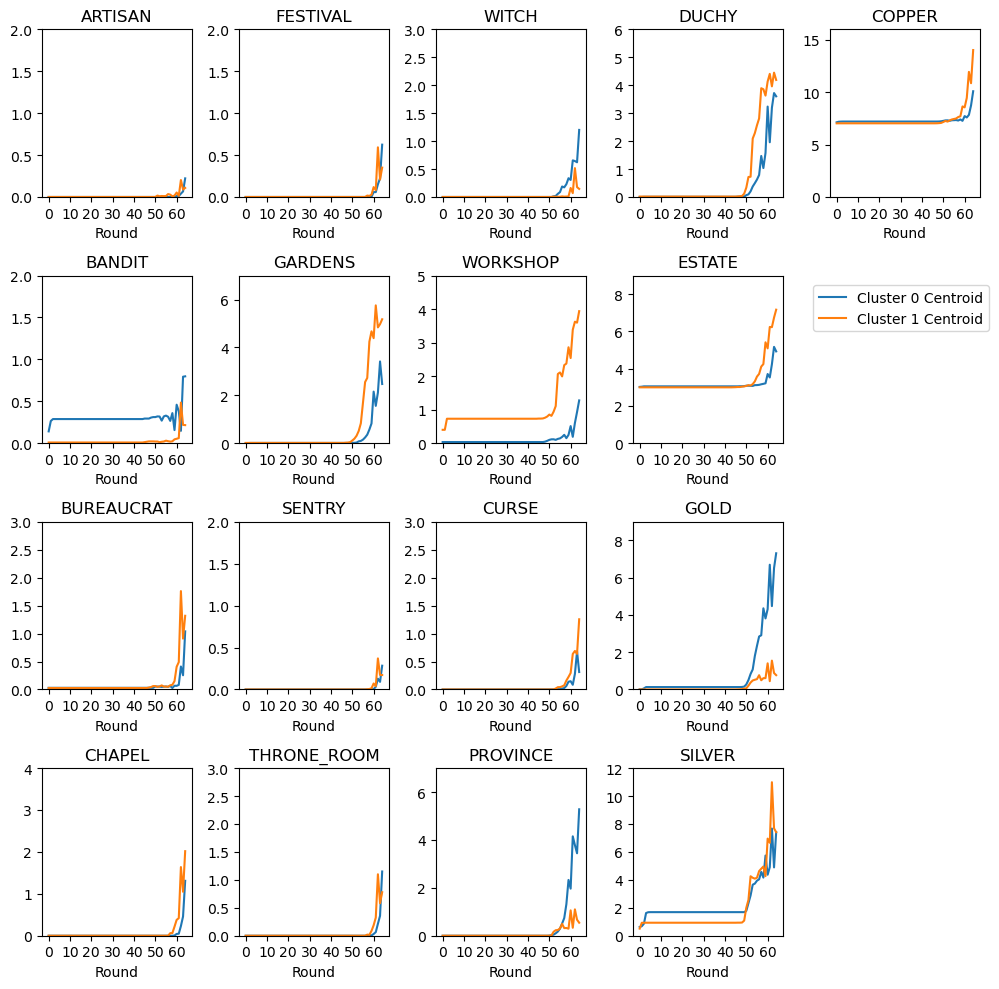

In [63]:
#compare centroids
def deck_evol_comparison(trace_list, label_list, cardTypes, maxRounds, legendOn = True):
    #look at evolution of number of cards of each type per round
    noOfCardTypes = len(cardTypes)
    noOfSubPlotCols = 5
    noOfSubPlotRows = max(2, math.floor(noOfCardTypes/noOfSubPlotCols) + 1)
    fig, axs = plt.subplots(noOfSubPlotRows, noOfSubPlotCols, figsize = (10,10))
    for i in range(0,noOfSubPlotRows):
        for j in range(0,noOfSubPlotCols):
            cardIndex = noOfSubPlotRows*j + i
            if cardIndex >= len(cardTypes):
                axs[i,j].set_visible(False)
            else:
                cardType = cardTypes[cardIndex]
                card_col = [cardType + "_R" + str(r) for r in range(0,maxRounds)]
                card_max = 0
                for (index, trace) in enumerate(trace_list):
                    axs[i,j].plot(range(0,maxRounds), trace[card_col].iloc[0], label = label_list[index])
                    tmp_card_max = int(trace[card_col].iloc[0].max())
                    if tmp_card_max > card_max:
                        card_max = tmp_card_max
                
                #set labels and limits
                axs[i,j].set_title(cardType)
                axs[i,j].set_xlabel('Round')
                axs[i,j].set_ylim((0,card_max+2))
                #axs[i,j].set_ylim((0,card_max))
                axs[i,j].set_xticks(ticks = range(0, maxRounds,10))
            
            #tighten subplots layout
            fig.tight_layout() 
            
    #add overal legend to figure
    if legendOn:
        axs[0,noOfSubPlotRows - 1].legend(loc = (1.2,-0.8))


def plot_cluster_centroids(no_of_clusters, cluster_centre_data, cardTypes, maxRounds):
    trace_list = []
    label_list = []
    for n in range(0, no_of_clusters):
        trace_list.append(pd.DataFrame(cluster_centre_data.iloc[n]).transpose())
        label_list.append(str('Cluster ') + str(n) + str(' Centroid'))
    deck_evol_comparison(trace_list, label_list, cardTypes, maxRounds)

plot_cluster_centroids(num_clusters, df_final_clusters, card_types, maxNoOfRounds)